# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 32

**Author 1 (sciper):** Julien Daniel Berger (247179)  
**Author 2 (sciper):** Ghali Chraibi (262251)   
**Author 3 (sciper):** Yasser Haddad (272292)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Imports

In [1]:
import tarfile
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import skimage.io
import skimage.morphology
from skimage import measure, io, img_as_ubyte
from skimage.color import label2rgb, rgb2gray
from skimage.exposure import histogram
from skimage.filters import gaussian, median, threshold_multiotsu, try_all_threshold, rank
from skimage.morphology import disk
from skimage.segmentation import watershed
from scipy import ndimage as ndi

In [2]:
import warnings
warnings.filterwarnings('ignore')

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [3]:
# Modify this variable according to the path of the data folder
data_base_path = "data"
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

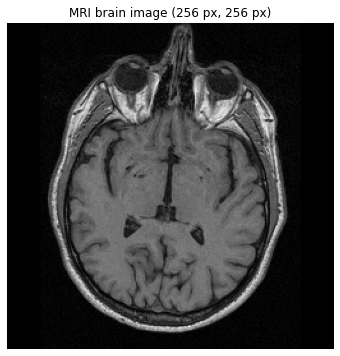

In [4]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Brain image pre-processing

Prior to any segmentation algorithms, we apply pre-processing steps to makes it easier to segment the brain without losing too much useful information. In our case, the main goal was to disconnect the brain with the rest of the skull.

We tried several techniques including histogram equalizer, the use of different kind of kernels and chose to keep the most relevant for our analysis. Note that every hyperparameters (size of the kernels, threshold) have been choosen empirically. 

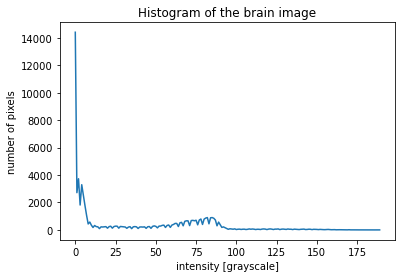

In [5]:
# Display the histogram of the image
hist, hist_centers = histogram(brain_im)
plt.plot(hist)
plt.title("Histogram of the brain image")
plt.xlabel("intensity [grayscale]")
plt.ylabel("number of pixels")
plt.show()

We observe through the histogram:
- a pic around 0 which corresponds mainly to the background
- and some pixels between 50 and 100 which corresponds mainly to the brain, mixed with dark part of the skull

In [6]:
### Pre-processing steps
# Add a Gaussian blur to remove gaussian noise
gaussian_brain = cv2.GaussianBlur(brain_im,(3,3),1)

# Apply a threshold to keep only the pixels with an intensity close to the brain
thresh_brain = cv2.inRange(gaussian_brain, 60, 90)

# Apply a median blur to remove salt-and-pepper kind noise
median_brain = cv2.medianBlur(thresh_brain,3)

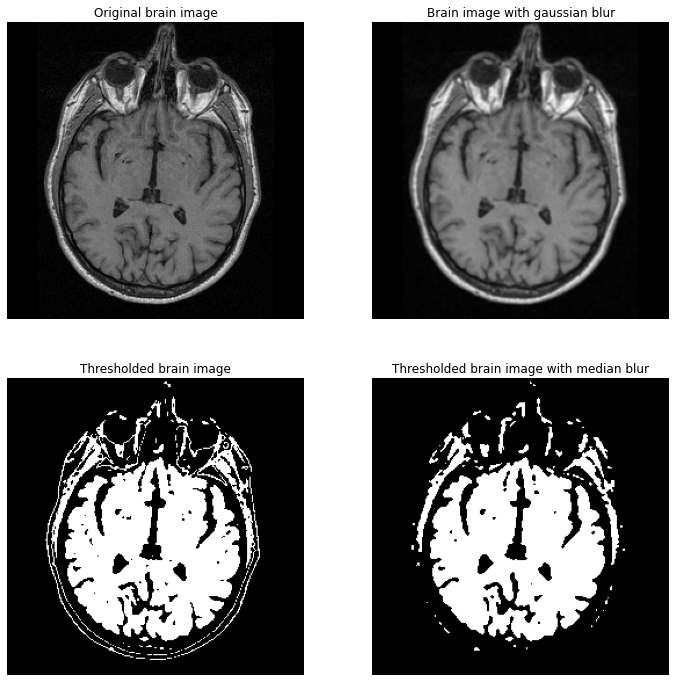

In [7]:
### Visualise the images at each step of the pre-processing
fig, ([ax1,ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 12))

# Original image
ax1.imshow(brain_im, cmap='gray')
ax1.set_title('Original brain image'.format(im_h, im_w))
ax1.axis('off')

# Image convolved with a gaussian filter
ax2.imshow(gaussian_brain, cmap='gray')
ax2.set_title('Brain image with gaussian blur'.format(im_h, im_w))
ax2.axis('off')

# Thresholded image
ax3.imshow(thresh_brain, cmap='gray')
ax3.set_title('Thresholded brain image'.format(im_h, im_w))
ax3.axis('off')

# Image convolved with a median filter
ax4.imshow(median_brain, cmap='gray')
ax4.set_title('Thresholded brain image with median blur'.format(im_h, im_w))
ax4.axis('off')

plt.show()

### 1.3 Region growing (5pts)

The first method we will use to segment the brain is region growing, a **region-based algorithm**.

The function used for the region growing algorithm is called `measure.label`. It allows to label connected pixels. Two pixels are connected when they are neighbors and have the same value.  

In [8]:
# Label the different objects 
labeled_im = measure.label(median_brain, background=None, connectivity=median_brain.ndim)
print("The image is segmented into {} objects.".format(len(np.unique(labeled_im))))

The image is segmented into 57 objects.


In [9]:
# Objects smaller than 1000 pixels are removed
labeled_im = skimage.morphology.remove_small_objects(labeled_im, min_size=1000)
print("There are {} objects that are bigger than 1000 pixels, The backround and the brain."
      .format(len(np.unique(labeled_im))))

There are 2 objects that are bigger than 1000 pixels, The backround and the brain.


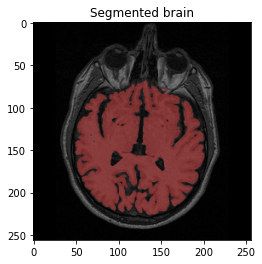

In [10]:
# Return an RGB image where color-coded labels are painted over the original image
labeled_im_color = label2rgb(labeled_im, image=brain_im, bg_label=0)
plt.imshow(labeled_im_color)
plt.title("Segmented brain");

In [11]:
# Compute the size of the labeled brain
brain_size1 = measure.regionprops_table(labeled_im, brain_im, properties=["area"])["area"][0]
print("With the region growing method, we find that the brain has a size of {} pixels".format(brain_size1))

With the region growing method, we find that the brain has a size of 15386 pixels


#### Disucussion

Region growing is a very simple and intuitive method which gives a quite precise segmentation of the brain, keeping its structure and its specificity. However, this method is very sensitive to noise. For the algorithm to work properly, some good pre-processing has to be done to remove unwanted connected pixels.

### 1.4 Contour detection (5pts)

The second method we will use to segment the brain is contour detection, a **contour-based algorithm**.

We use openCV's `findContours` to do contour detection. We apply it to the image we get after the median blur. We use `cv2.RETR_TREE` as contour retrieval mode and `cv2.CHAIN_APPROX_SIMPLE` as countour approximation to only store the endpoints of a line in a countour. Finally we use `contoursArea` to compute the area delimited by each contours (keeping only the relevant parts).

In [12]:
# Find the contours of our brain image
contours, _ = cv2.findContours(median_brain, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours by area covered within the contours
contours = sorted(contours, key=cv2.contourArea, reverse=True)

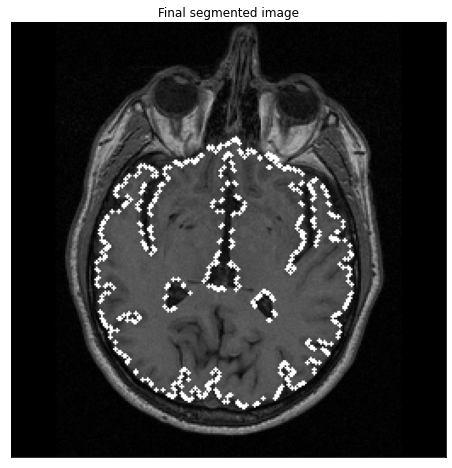

In [13]:
# Visualise the contours
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

img = brain_im.copy()
img = cv2.drawContours(img, contours[0], -1, (255,255,255), 2)
img = cv2.drawContours(img, contours[1], -1, (255,255,255), 2)
img = cv2.drawContours(img, contours[5], -1, (255,255,255), 2)
img = cv2.drawContours(img, contours[6], -1, (255,255,255), 2)

ax.imshow(img, cmap='gray')
ax.set_title('Final segmented image')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [14]:
# Compute the overall area of the brain in pixels
area = (cv2.contourArea(contours[0]) - cv2.contourArea(contours[1])
        - cv2.contourArea(contours[5]) - cv2.contourArea(contours[6]))

print("With the contour detection method, we find that the brain has a size of {} pixels".format(int(area)))

With the contour detection method, we find that the brain has a size of 15465 pixels


#### Discussion

The contour detection method gives also quite accurate results to segment the brain. It has though a drawback as it requires human intervention to choose which contours to include or exclude and it is even sometimes difficult for a human to decide just looking at the picture.

### 1.5 Additional method (5pts)

The watershed method is a **region-based** segmentation algorithm and it works only on grayscale images. It considers the image as a *topographic landscape*, with valleys and ridges. The typical elevation values are either the grayscale value of a pixel or the gradient magnitude. 

The user defines markers that characterizes the objects on the image. Based on the landscape defined by those markers, the watershed algorithm decomposes the images into *basins*, valleys that have a local minima at their lowest point. Watersheds separate basins from one another. The goal of the algorithm is to *merge* those basins by “flooding them”. This is how regions are segmented using this method.

We apply this algorithm in the following way:
- We first apply an **opening with a rectangular kernel** to get rid of the elements just above the brain, that can get detected as part of it with the watershed method.
- We will apply the watershed method on the **gradient of the image**. The gradient allows us to separate the background from the brain.
- We create the markers based on the values of the gradient of the image.
- We then apply the watershed method on the gradient and the markers.
- Finally, we keep the region of interest, which is the brain.

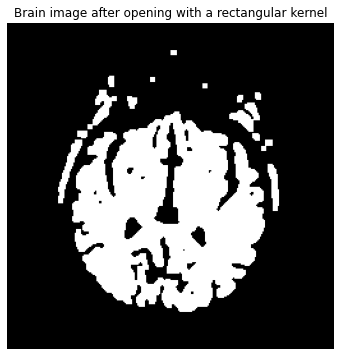

In [15]:
kern_rect = cv2.getStructuringElement(cv2.MORPH_RECT,(4,4))
opening_brain = cv2.morphologyEx(median_brain, cv2.MORPH_OPEN, kern_rect)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(opening_brain, cmap='gray')
ax.set_title('Brain image after opening with a rectangular kernel')
ax.axis('off')
plt.show()

In [16]:
# Gradient computed with a neighborhood corresponding to a disk of radius 2
gradient = rank.gradient(opening_brain, disk(2))

np.unique(gradient)

array([  0, 255], dtype=uint8)

Only two values are possible for the magnitude of the gradient : 0 and 255. This makes sense as the sharp transitions happen at the moment when the colors go from black to white (the switch from background to the brain). The markers used are extracted by labeling low gradient regions that are equal to 0.

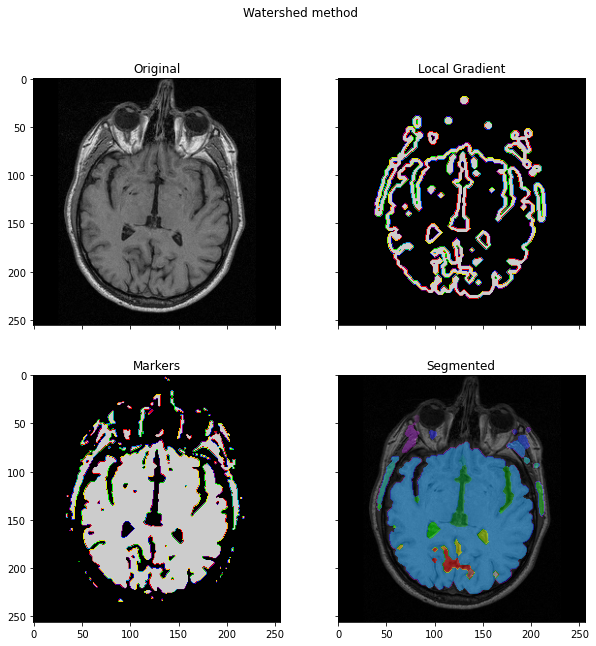

In [17]:
# Get the markers by labeling low gradient regions
markers = rank.gradient(opening_brain, disk(2)) < 255
markers = ndi.label(markers)[0]

# Process the watershed
labels = watershed(gradient, markers)

# Display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(median_brain, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(brain_im, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmented")

fig.suptitle("Watershed method")

plt.show()

The watershed algorithm detects the gaps in the brain and does not include them in the brain region. However, we see that it excludes some very small parts.

In [18]:
# Compute areas of all extracted regions
areas = {val: np.sum(labels==val) for val in np.unique(labels)}

# Sort extracted regions by descending area
areas = sorted(areas.items(), key=lambda k: k[1], reverse=True) 

# Get the index of the area corresponding to the brain
index_area = areas[1][0]

print("With the watershed method, we find that the brain has a size of {} pixels".format(areas[1][1]))

With the watershed method, we find that the brain has a size of 15656 pixels


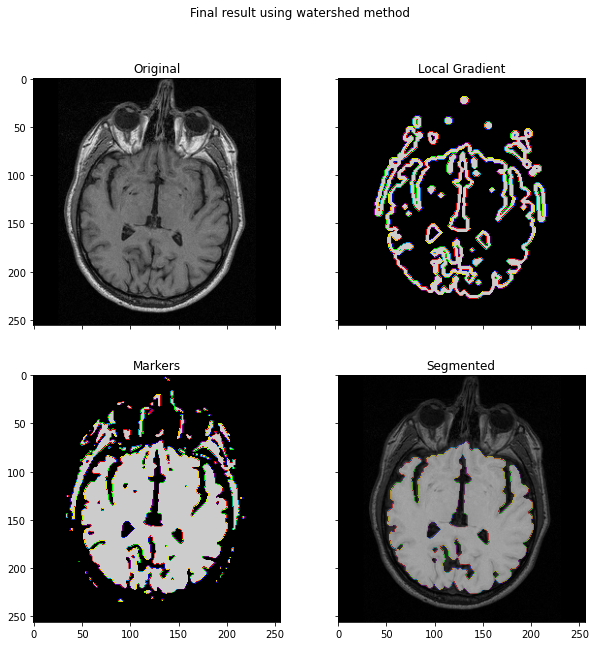

In [19]:
# Create mask around the extracted area
mask = np.zeros(labels.shape)
mask[labels == index_area] = index_area

# Display final results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(median_brain, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(brain_im, cmap=plt.cm.gray)
ax[3].imshow(mask, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmented")

fig.suptitle("Final result using watershed method")

plt.show()

#### Discussion 

- The watershed method is able of correctly extracting most of the brain's region.
- It is interactive, as it depends heavily on the inputs of the user. This means that we had to find good settings empirically.
- This method is prone to *over-segmentation*, as it treats each pixel as a watershed or a region. This means that small regions can be detected, and these small regions are generally part of a bigger region that is not well detected.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [20]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


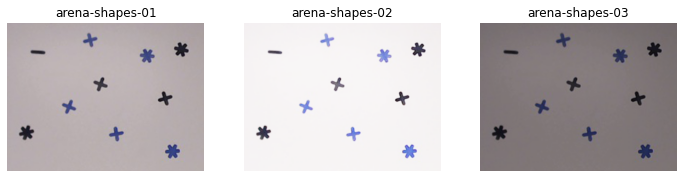

In [21]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts) & Total area (in pixels) of each color (5 pts)

The challenge here is to segment in a consistant way shapes of different colors with different illuminations. To tackle this challenge we choose the unsupervised **kmeans** algorithm to detect the different clusters and label each pixel in one of the computed cluster.

Kmeans usually cluster points using a distance metric. The trick here is to consider our image as a list of pixels and cluster them by their RGB values. Hence the k given centroids are directly the k principle colors in our image.

We think kmeans is an appropriate method to solve such task with illumination contraints as it should not care of whether the colors are darker or lighter as it just separate them into cluster without the prior knowledge of what they are.

In [22]:
def segment_with_kmeans(image, nbr_cluster):
    
    ### 1. Reformat the image so that it is compatible with the cv.kmeans() function
    # Reshape the image to a 2D array: the pixels are flattened and we keep the 3 channels (RGB)
    pixel_values = image.reshape((-1, 3))
    # Convert the pixels in float
    pixel_values = np.float32(pixel_values)
    
    ### 2. Apply kmeans algorithm on the (reformated) image
    # Define a stopping criteria:
    #    1. Either we reach an accuracy of epsilon (0.1)
    #    2. Or we have performed the specified number of iteration (1000)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.1)
    _, labels, (centers) = cv2.kmeans(pixel_values, nbr_cluster, None, criteria, 50, cv2.KMEANS_RANDOM_CENTERS)
    
    ### 3. Transform the data back to an image format
    # Convert back the 3 colors (corresponding to the 3 centers) in 8 bit values
    centers = np.uint8(centers)
    # Convert all pixels to the color of their associated centroids
    segmented_image = centers[labels.flatten()]
    # Reshape the pixels back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image, labels.flatten(), centers

In [23]:
def extract_shapes_of_same_color(segmented_image, labels, centers):
    masked_images = []
    
    # For each cluster append a masked_image displaying only the shapes of the same cluster (color)
    for i in range(len(centers)):
        masked_image = segmented_image.copy()
        # Convert the segmented image to the shape of a vector of pixel values
        masked_image = masked_image.reshape((-1, 3))
        
        # Put in black every pixel that does not belong to the current cluster (i)
        masked_image[labels != i] = [0, 0, 0]
        
        # Reshape the image
        masked_image = masked_image.reshape(segmented_image.shape)
        
        masked_images.append((masked_image, centers[i]))
        
    return masked_images

In [24]:
def extract_characteristics_from_bicolored_image(masked_image, color):
    
    # Convert the masked image into a grayscale image (in fact black and white in our case)
    mask = np.full(masked_image.shape, color) 
    binary_im = img_as_ubyte(masked_image == mask)
    
    # Apply a median blur to remove some noise generated by kmeans and the extraction
    binary_im = cv2.medianBlur(binary_im, 5)  
    
    ### To count the number of shapes, we have to make a region growing on the binary image 
    # Label the different objects 
    labeled_im = measure.label(binary_im, background=None, connectivity=binary_im.ndim)
    # Objects smaller than 500 pixels are removed
    labeled_im = skimage.morphology.remove_small_objects(labeled_im, min_size=500)
    # Obtain a list with the size of each object
    list_area = measure.regionprops_table(labeled_im, masked_image, properties=["area"])["area"]
    
    return binary_im, len(list_area), list_area.sum()


For image 0
	For color 0: There are 5 shapes with a total area of 15771 pixels
	For color 1: There are 1 shapes with a total area of 889890 pixels
	For color 2: There are 5 shapes with a total area of 12015 pixels


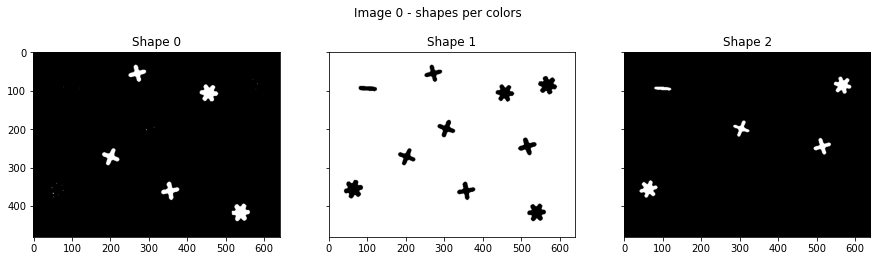


For image 1
	For color 0: There are 5 shapes with a total area of 13857 pixels
	For color 1: There are 1 shapes with a total area of 893565 pixels
	For color 2: There are 5 shapes with a total area of 10461 pixels


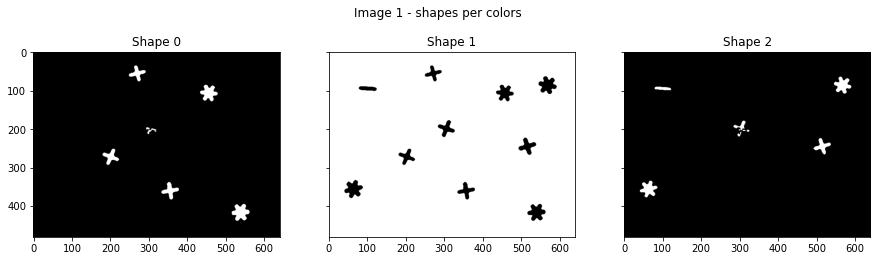


For image 2
	For color 0: There are 5 shapes with a total area of 16143 pixels
	For color 1: There are 5 shapes with a total area of 12042 pixels
	For color 2: There are 1 shapes with a total area of 889122 pixels


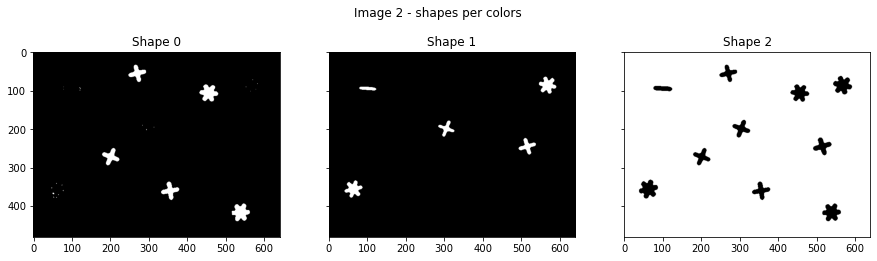

In [25]:
# For each image, count the number of shapes/pixels of each color
for i, image in enumerate(images):
    
    # Apply the pipeline
    segmented_image, labels, centers = segment_with_kmeans(image, 3)
    masked_images = extract_shapes_of_same_color(segmented_image, labels, centers)
    print("\nFor image {}".format(i))
    
    binary_imgs = []
    for j, masked_image in enumerate(masked_images):
        binary_img, nbr_shapes, area = extract_characteristics_from_bicolored_image(masked_image[0], masked_image[1])
        binary_imgs.append(binary_img)
        print("\tFor color {}: There are {} shapes with a total area of {} pixels".format(j, nbr_shapes, area))
        
    # Display the results
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=True)

    axes[0].imshow(binary_imgs[0])
    axes[0].set_title("Shape 0")

    axes[1].imshow(binary_imgs[1])
    axes[1].set_title("Shape 1")

    axes[2].imshow(binary_imgs[2])
    axes[2].set_title("Shape 2")

    fig.suptitle("Image {} - shapes per colors".format(i))

    plt.show()
    

#### Discussion

Kmeans gives quite accurate segmentation of colored image and is relatively robust to different illuminations with appropriate pre-processing steps. It counts quite precisely the number of shape of each color (cluster), but is less consistant counting the total area of each color (kmeans use some randomness in its algorithm, e.g. choosing the cluster in the first iteration).

We note though the following downside using this method:
1. We need to know the number of colors (clusters) before running the algorithm (if the data is not known).  
This can be solved by using the Elbow method to find which k is the best, prior to run the algorithm.

2. Some change in illuminations can have a visible impact on the segmentation process, as a change in illumination does not have a one-to-one translation in the RGB scale. Thus homegeneously colored shape can produce heterogeneously colored shape in the RGB scales when special illuminations occur, which can slightly deteriorate the segmentation process when using kmeans. Such event can be observed in image 1 (the counts of shapes are correct, but it impacts the overall area of some colors).    
This problem could be solved working with an HSB scale where the segmentation in colors could benefit of the Hue channel and the illumination effects could be handle with the Brigthness channel.

Still kmeans is an appropriate algorithm to solve such task providing useful informations in colored images.